In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import geopandas as geopd
import json
import numpy as np
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from ses_ling.utils.paths import ProjectPaths
import ses_ling.data.socioeconomic as ses_data
import ses_ling.utils.sim as sim_utils
import ses_ling.utils.stats as stats_utils
from ses_ling.language import Language

In [123]:
paths = ProjectPaths()

# Toy example

In [4]:
nr_classes = 2
nr_cells = 2
nr_variants = 2
nr_low_ses = 100
nr_high_ses = 100
nr_agents = nr_low_ses + nr_high_ses
ses_distrib = [0] * nr_low_ses + [1] * nr_high_ses
variant_distrib = ses_distrib
# variant_distrib = [0] * (nr_low_ses - 10) + [1] * 10 + [1] * (nr_high_ses - 10) + [0] * 10
cell_distrib = ses_distrib

In [5]:
lv = 0.6
l_arr = np.array([lv, 1-lv])
q1 = 0.8
q2 = 0.5
# to make computation easier, in the following array suppose the given qs are all
# preference for variant 0 of the SES classes, hence the 1-q2
q_arr = np.array([q1, 1-q2])

In [170]:
prop_moving_in_low_ses = 0.5 # that's ms1
prop_moving_in_high_ses = 0.5 # prop_moving_in_low_ses
mob_matrix = np.array([
    [1 - prop_moving_in_low_ses, prop_moving_in_low_ses],
    [prop_moving_in_high_ses, 1 - prop_moving_in_high_ses]
])

In [171]:
sim = sim_utils.Simulation(
    {'ses': ses_distrib, 'res_cell': cell_distrib, 'variant': variant_distrib,},
    mob_matrix,
    l_arr,
    q_arr,
)

In [19]:
sim.run(200)

0.0 switched variant: 100%|███████████████████| 200/200 [00:02<00:00, 87.64it/s]


<Axes: xlabel='time', ylabel='agents using standard form'>

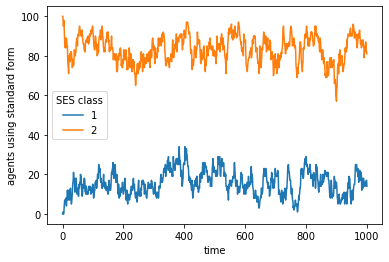

In [16]:
ax = sim.plot_evol()

neutral ling variables and see what mobility brings

nr people in cells with time, 

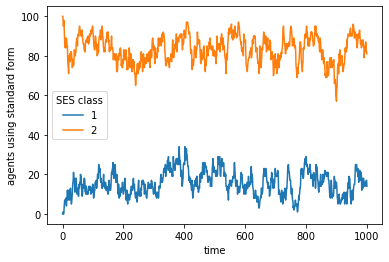

In [223]:
ax = sim.plot_evol(
    lv=lv, q1=q1, q2=q2, ms1=prop_moving_in_low_ses, ms2=prop_moving_in_high_ses
)
ax.set_title("")
ax.get_figure().savefig("low_pref_res.pdf")

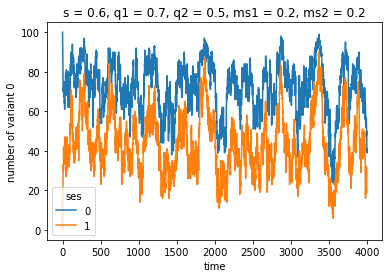

In [41]:
ax = sim.plot_evol(
    lv=lv, q1=q1, q2=q2, ms1=prop_moving_in_low_ses, ms2=prop_moving_in_high_ses
)

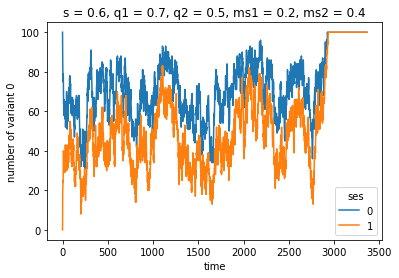

In [32]:
ax = sim.plot_evol(
    lv=lv, q1=q1, q2=q2, ms1=prop_moving_in_low_ses, ms2=prop_moving_in_high_ses
)

Text(0.5, 1.0, 's = 0.6, q1 = 0.7, q2 = 0.5, ms1=0.5, ms2=0.5')

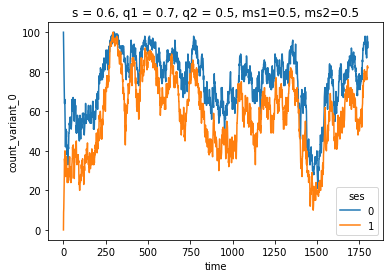

In [271]:
ax = sim.plot_evol(
    lv=lv, q1=q1, q2=q2, ms1=prop_moving_in_low_ses, ms2=prop_moving_in_high_ses
)

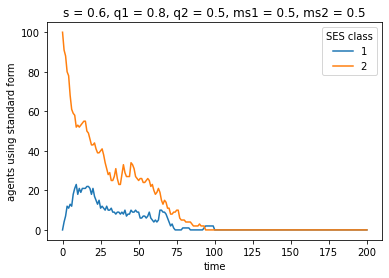

In [20]:
ax = sim.plot_evol(
    lv=lv, q1=q1, q2=q2, ms1=prop_moving_in_low_ses, ms2=prop_moving_in_high_ses
)

# Real mobility

## Setup

In [4]:
all_cntr_shapes = geopd.read_file(paths.countries_shapefile)

In [5]:
with open(paths.ext_data / 'countries.json') as f:
    countries_dict = json.load(f)
cc = 'GB'
cc_dict = countries_dict[cc]
year_from = 2015
year_to = 2021
res_attr_kwargs = dict(
    nighttime_acty_th=0.5,
    all_acty_th=0.1,
    count_th=3,
    gps_dups_th=500,
    pois_dups_th=500,
)

In [6]:
_cc_init_params = {
    cc: {'cell_size': 'MSOA_BGC', 'ses_idx': "net_income18", "res_cell_size": "MSOA_BGC"}
}
lang = Language(
    'en', 'English', _cc_init_params, countries_dict,
    all_cntr_shapes=all_cntr_shapes,
    year_from=year_from, year_to=year_to,
    latlon_proj=cc_dict['xy_proj'], # TOCHANGE when several countries
    user_nr_words_th=100,
    cells_nr_users_th=15,
    res_attr_kwargs=res_attr_kwargs,
)
reg = lang.regions[0]

shape_geodf loaded for GB
ses_df loaded for GB
cell_levels_corr loaded for GB
lt_rules loaded for GB
regions done
done


In [7]:
lang.add_ses_idx('msoa_pop')

In [8]:
focus_cities = [
    'London', 'Manchester', 'Birmingham', 'Liverpool', 'Leeds', 'Sheffield', 
    'Newcastle upon Tyne', 'Bristol, City of'
]
subregions_dict = {c: 'rgn20nm' if c == 'London' else 'lad20nm' for c in focus_cities}
subreg_df = pd.DataFrame.from_dict({'GB': subregions_dict}, orient='index').stack().rename_axis(index=['cc', 'subreg']).rename('agg_col').to_frame().set_index('agg_col', append=True)

metro_areas = pd.read_csv(lang.paths.ext_data / lang.regions[0].cell_levels_corr_files['metro_area'])
subreg_df = subreg_df.join(metro_areas.set_index('metro_area')['LAD20CD'], on='subreg')

## Sim

### City loop

In [ ]:
lv = 0.6
l_arr = np.array([lv, 1-lv])
q1 = 0.8
q2 = 0.5
# to make computation easier, in the following array suppose the given qs are all
# preference for variant 0 of the SES classes, hence the 1-q2
q_arr = np.array([q1, 1-q2])

In [199]:
nr_classes = 2
lang.cells_nr_users_th = 15
exclude_res_trips = False
normalize_incoming = False
assort_dict = {}
for city, city_d in lang.iter_subregs(
    subreg_df, ses_metric='net_income18', include_pop=True
):
    assort = ses_data.user_acty_to_assort(
        nr_classes=nr_classes,
        exclude_res_trips=True,
        normalize_incoming=normalize_incoming,
        **city_d,
    )
    pearsonr = stats_utils.matrix_pearsonr(assort.values)
    assort_dict[city] = {'assort': assort, 'pearsonr': pearsonr}

    masks_dict = {'cell_id': city_d['cells_mask']}
    cells_subset_ses_metric = ses_data.apply_masks(city_d['cells_ses_metric'], masks_dict)
    masks_dict['user_id'] = city_d.get('users_mask')
    cells_subset_user_res = ses_data.apply_masks(city_d['user_res_cell'], masks_dict)
    cells_pop = city_d['cells_pop']
    cells_class = ses_data.attr_cell_to_class(
        cells_subset_ses_metric, nr_classes, cells_pop
    )
    cells_subset_user_acty = ses_data.preprocess_cell_acty(
        city_d['user_cell_acty'], cells_subset_user_res, masks_dict, exclude_res_trips
    )
    od_df = (
        cells_subset_user_acty.groupby(['res_cell_id', 'cell_id'])[['prop_cell']].sum()
    )
    od_groupby_col = 'cell_id' if normalize_incoming else 'res_cell_id'
    od_df = od_df / od_df.groupby(od_groupby_col).transform('sum')

    mob_matrix = (
        od_df['prop_cell'].unstack()
        .fillna(0)
        .reindex(index=cells_pop.index.rename('res_cell_id'))
        .reindex(columns=cells_pop.index.rename('cell_id'))
    )
    agents = {
        'res_cell': sum([[i] * pop for i, pop in enumerate(cells_pop.values)], start=[]),
        'ses': sum(
            [
                [cell_class] * pop
                for cell_class, pop in zip(cells_class.reindex(cells_pop.index) - 1, cells_pop)
            ],
            start=[],
        ),
    }
    agents['variant'] = agents['ses']
    sim = sim_utils.Simulation.from_dict(
        city, agents, mob_matrix, lv, q1, q2, cells_nr_users_th=lang.cells_nr_users_th
    )
    sim.save_state()

** Birmingham **
285 cells in Birmingham.
Keeping 4879 cells out of 7201, 2322 discarded from `cells_nr_users_th`
95 cells left after masking cells where there are fewer than  15 residents
47.5 cells on average in each of the 2 classes.
34.8% of users and 86.7% of trips removed from exclusion of residence trips
47.5 cells on average in each of the 2 classes.
** Bristol, City of **
55 cells in Bristol, City of.
41 cells left after masking cells where there are fewer than  15 residents
20.5 cells on average in each of the 2 classes.
32.1% of users and 84.2% of trips removed from exclusion of residence trips
20.5 cells on average in each of the 2 classes.
** Leeds **
168 cells in Leeds.
105 cells left after masking cells where there are fewer than  15 residents
52.5 cells on average in each of the 2 classes.
28.6% of users and 82.7% of trips removed from exclusion of residence trips
52.5 cells on average in each of the 2 classes.
** Liverpool **
139 cells in Liverpool.
122 cells left afte

In [155]:
sim.save_state()

### Nured

In [ ]:
param_incr = 0.05
nr_digits = len(str(param_incr)) - 2
nr_steps = 500
cells_nr_users_th = 0
c = 0
args = []
for lv in np.arange(0.5, 1, param_incr):
    q1_vals = np.arange(lv + param_incr, 1, param_incr)
    q2_vals = np.arange(0.5, lv + param_incr/10, param_incr)
    for q2 in q2_vals:
        for q1 in q1_vals:
            args.append(
                f"{round(lv, nr_digits)} {round(q1, nr_digits)} {round(q2, nr_digits)}"
                f" {cells_nr_users_th} {nr_steps}"
            )

In [ ]:
run_path = "/home/thomaslouf/local/bin/run.py"
sim_utils.nured_run('city_sim.py', args, 4*60, run_path=run_path)

export PATH=$PATH:/common/slurm/bin;cd /home/thomaslouf/Documents/code/ses-ling/scripts;/home/thomaslouf/local/bin/run.py -t 240 -o /home/thomaslouf/Documents/code/ses-ling/scripts/logs/city_sim_2023-04-13T12:30:50.4880_out.log -e /home/thomaslouf/Documents/code/ses-ling/scripts/logs/city_sim_2023-04-13T12:30:50.4880_err.log "/home/thomaslouf/.conda/envs/ses-ling/bin/python city_sim.py 0.5 0.55 0.5 0 500";/home/thomaslouf/local/bin/run.py -t 240 -o /home/thomaslouf/Documents/code/ses-ling/scripts/logs/city_sim_2023-04-13T12:30:50.4881_out.log -e /home/thomaslouf/Documents/code/ses-ling/scripts/logs/city_sim_2023-04-13T12:30:50.4881_err.log "/home/thomaslouf/.conda/envs/ses-ling/bin/python city_sim.py 0.5 0.6 0.5 0 500";/home/thomaslouf/local/bin/run.py -t 240 -o /home/thomaslouf/Documents/code/ses-ling/scripts/logs/city_sim_2023-04-13T12:30:50.4882_out.log -e /home/thomaslouf/Documents/code/ses-ling/scripts/logs/city_sim_2023-04-13T12:30:50.4882_err.log "/home/thomaslouf/.conda/envs/se

In [ ]:

s = sim_utils.Simulation.from_saved_state('London', q1=q1, lv=lv, q2=q2, step=500, cells_nr_users_th=15)
ses_x_variant = s.agent_df.groupby(['ses', 'variant']).size()
ses_x_variant = ses_x_variant / ses_x_variant.groupby('ses').sum()
print(stats_utils.matrix_pearsonr(ses_x_variant.unstack().values))

In [201]:
lang.cells_nr_users_th = 15
exclude_res_trips = True
normalize_incoming = False
assort_dict = {}
for city, city_d in lang.iter_subregs(
    subreg_df, ses_metric='net_income18', include_pop=True
):
    # TODO: do for 2 classes to be consistent with simulation?
    assort = ses_data.user_acty_to_assort(
        nr_classes=nr_classes,
        exclude_res_trips=True,
        normalize_incoming=normalize_incoming,
        **city_d,
    )
    pearsonr = stats_utils.matrix_pearsonr(assort.values)
    assort_dict[city] = {'assort': assort, 'pearsonr': pearsonr}

** Birmingham **
285 cells in Birmingham.
Keeping 4879 cells out of 7201, 2322 discarded from `cells_nr_users_th`
95 cells left after masking cells where there are fewer than  15 residents
47.5 cells on average in each of the 2 classes.
34.8% of users and 86.7% of trips removed from exclusion of residence trips
** Bristol, City of **
55 cells in Bristol, City of.
41 cells left after masking cells where there are fewer than  15 residents
20.5 cells on average in each of the 2 classes.
32.1% of users and 84.2% of trips removed from exclusion of residence trips
** Leeds **
168 cells in Leeds.
105 cells left after masking cells where there are fewer than  15 residents
52.5 cells on average in each of the 2 classes.
28.6% of users and 82.7% of trips removed from exclusion of residence trips
** Liverpool **
139 cells in Liverpool.
122 cells left after masking cells where there are fewer than  15 residents
61.0 cells on average in each of the 2 classes.
25.7% of users and 79.2% of trips remov

Text(0.5, 0, 'Assortativity')

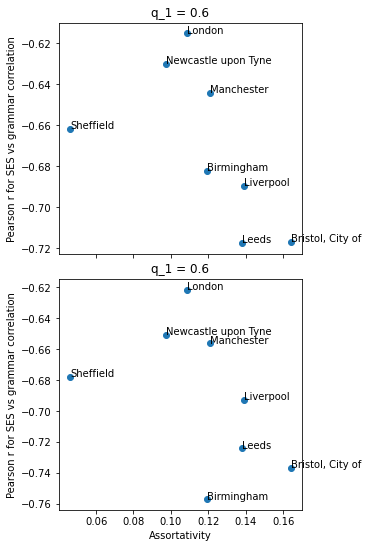

In [202]:
fig, axes = plt.subplots(2, figsize=(5, 1.5*5), constrained_layout=True, sharex=True)
for ax, cells_nr_users_th in zip(axes, (0, 15)):
    y = []
    for city in focus_cities:
        s = sim_utils.Simulation.from_saved_state(
            city, q1=0.8, lv=0.6, q2=0.5, step=500, cells_nr_users_th=cells_nr_users_th
        )
        ses_x_variant = s.agent_df.groupby(['ses', 'variant']).size()
        ses_x_variant = ses_x_variant / ses_x_variant.groupby('ses').sum()
        y.append(-stats_utils.matrix_pearsonr(ses_x_variant.unstack().values))
    # y = [-ses_x_grammar_dict[q1][city] for city in focus_cities]
    x = [assort_dict[city]['pearsonr'] for city in focus_cities]
    annots = [ax.annotate(city, (xc, yc)) for city, xc, yc in zip(focus_cities, x, y)]
    ax.scatter(x, y)
    # adj_text_kw = {
    #     'expand_points': (1.2, 1.5),
    #     'expand_text': (1.2, 2),
    #     'arrowprops': {'arrowstyle': '-', 'color': 'gray', 'lw': 1},
    # }
    # adjust_text(annots, x=x, y=y, ax=ax, **adj_text_kw)
    ax.set_ylabel('Pearson r for SES vs grammar correlation')
    ax.set_title(f"q_1 = {q1}")
ax.set_xlabel("Assortativity")

### London

In [ ]:
nr_classes = 2
exclude_res_trips = False
normalize_incoming = False
for city, city_d in lang.iter_subregs(
    subreg_df, selected_subregs=['London'], ses_metric='net_income18', include_pop=True
):
    masks_dict = {'cell_id': city_d['cells_mask']}
    cells_subset_ses_metric = ses_data.apply_masks(city_d['cells_ses_metric'], masks_dict)
    masks_dict['user_id'] = city_d.get('users_mask')
    cells_subset_user_res = ses_data.apply_masks(city_d['user_res_cell'], masks_dict)
    cells_pop = city_d['cells_pop']
    cells_class = ses_data.attr_cell_to_class(
        cells_subset_ses_metric, nr_classes, cells_pop
    )
    cells_subset_user_acty = ses_data.preprocess_cell_acty(
        city_d['user_cell_acty'], cells_subset_user_res, masks_dict, exclude_res_trips
    )
    od_df = (
        cells_subset_user_acty.groupby(['res_cell_id', 'cell_id'])[['prop_cell']].sum()
    )
    od_groupby_col = 'cell_id' if normalize_incoming else 'res_cell_id'
    od_df = od_df / od_df.groupby(od_groupby_col).transform('sum')

** London **
983 cells in London.
652 cells left after masking cells where there are fewer than  15 residents
326.0 cells on average in each of the 2 classes.


In [307]:
agents = {
    'res_cell': sum([[i] * pop for i, pop in enumerate(cells_pop.values)], start=[]),
    'ses': sum(
        [
            [cell_class] * pop
            for cell_class, pop in zip(cells_class.reindex(cells_pop.index) - 1, cells_pop)
        ],
        start=[],
    ),
}
agents['variant'] = agents['ses']

In [308]:
mob_matrix = (
    od_df['prop_cell'].unstack()
     .fillna(0)
     .reindex(index=cells_pop.index.rename('res_cell_id'))
     .reindex(columns=cells_pop.index.rename('cell_id'))
     .to_numpy()
)

In [309]:
london_sim = sim_utils.Simulation.from_dict(city, agents, mob_matrix, lv, q1, q2)

In [310]:
london_sim.run(100)

401821 switched variant: 100%|████████████████| 100/100 [35:34<00:00, 21.35s/it]


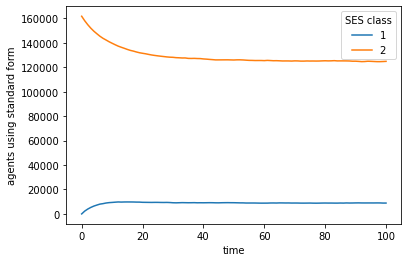

In [ ]:
ax = london_sim.plot_evol()

In [328]:
stats_utils.matrix_pearsonr(london_sim.agent_df.groupby(['ses', 'variant']).size().unstack().values)

0.6225331146958378

In [331]:
stats_utils.matrix_pearsonr(bham_sim.agent_df.groupby(['ses', 'variant']).size().unstack().values)

0.7841606525261515

In [311]:
variant_by_cell = london_sim.agent_df.groupby(['cell', 'variant']).size()
prop_variant_by_cell = variant_by_cell / variant_by_cell.groupby('cell').sum()
cell_entropy = (- prop_variant_by_cell * np.log(prop_variant_by_cell)).groupby('cell').sum() / np.log(london_sim.nr_classes)
variant_mixing = prop_variant_by_cell.groupby('cell').min().set_axis(city_d['cells_pop'].index).rename('variant_mixing')

In [312]:
lang.map_interactive(variant_mixing)

In [313]:
polar_variant0 = prop_variant_by_cell.loc[(slice(None), 0)].add(
    -prop_variant_by_cell.loc[(slice(None), 1)], fill_value=0
).set_axis(city_d['cells_pop'].index).rename('polar_variant0')

In [314]:
lang.map_interactive(polar_variant0)

In [315]:
mob_matrix_in_pop = (london_sim.mob_matrix.T * city_d['cells_pop'].values).T
cell_inc_mob = pd.Series(mob_matrix_in_pop.sum(axis=0), name='incoming_mob', index=city_d['cells_pop'].index)

In [317]:
lang.map_interactive(cell_inc_mob)

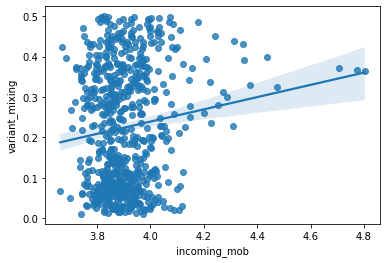

In [316]:
ax = sns.regplot(
    x=np.log10(cell_inc_mob),
    y=variant_mixing,
)

### Bristol

In [291]:
bristol_sim = sim_utils.Simulation.from_dict(city, agents, mob_matrix, lv, q1, q2)

In [294]:
bristol_sim.run(100)

19659 switched variant: 100%|█████████████████| 100/100 [00:20<00:00,  4.81it/s]


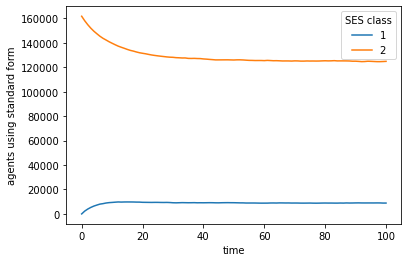

In [295]:
ax = bristol_sim.plot_evol()

In [296]:
variant_by_cell = bristol_sim.agent_df.groupby(['cell', 'variant']).size()
prop_variant_by_cell = variant_by_cell / variant_by_cell.groupby('cell').sum()
cell_entropy = (- prop_variant_by_cell * np.log(prop_variant_by_cell)).groupby('cell').sum() / np.log(bristol_sim.nr_classes)
variant_mixing = prop_variant_by_cell.groupby('cell').min().set_axis(city_d['cells_pop'].index).rename('variant_mixing')

In [297]:
lang.map_interactive(variant_mixing)

In [298]:
polar_variant0 = prop_variant_by_cell.loc[(slice(None), 0)].add(
    -prop_variant_by_cell.loc[(slice(None), 1)], fill_value=0
).set_axis(city_d['cells_pop'].index).rename('polar_variant0')

In [299]:
lang.map_interactive(polar_variant0)

In [300]:
mob_matrix_in_pop = (bristol_sim.mob_matrix.T * city_d['cells_pop'].values).T
cell_inc_mob = pd.Series(mob_matrix_in_pop.sum(axis=0), name='incoming_mob', index=city_d['cells_pop'].index)

In [301]:
lang.map_interactive(cell_inc_mob)

### BHam

In [111]:
bham_sim = sim_utils.Simulation.from_dict(city, agents, mob_matrix, lv, q1, q2)

In [112]:
bham_sim.run(100)

36759 switched variant: 100%|█████████████████| 100/100 [00:56<00:00,  1.78it/s]


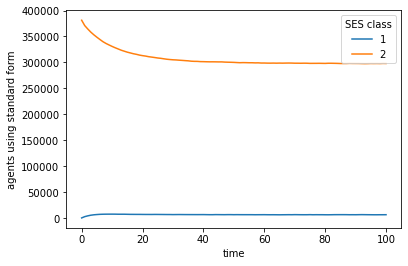

In [231]:
ax = bham_sim.plot_evol()

In [ ]:
variant_by_cell = bham_sim.agent_df.groupby(['cell', 'variant']).size()
prop_variant_by_cell = variant_by_cell / variant_by_cell.groupby('cell').sum()
cell_entropy = (- prop_variant_by_cell * np.log(prop_variant_by_cell)).groupby('cell').sum() / np.log(bham_sim.nr_classes)
variant_mixing = prop_variant_by_cell.groupby('cell').min().set_axis(city_d['cells_pop'].index).rename('variant_mixing')

In [ ]:
lang.map_interactive(variant_mixing)

In [ ]:
polar_variant0 = prop_variant_by_cell.loc[(slice(None), 0)].add(
    -prop_variant_by_cell.loc[(slice(None), 1)], fill_value=0
).set_axis(city_d['cells_pop'].index).rename('polar_variant0')

In [ ]:
lang.map_interactive(polar_variant0)

In [ ]:
mob_matrix_in_pop = (bham_sim.mob_matrix.T * city_d['cells_pop'].values).T
cell_inc_mob = pd.Series(mob_matrix_in_pop.sum(axis=0), name='incoming_mob', index=city_d['cells_pop'].index)

In [ ]:
lang.map_interactive(cell_inc_mob)

# Sanity checks

In [196]:
nr_classes = 2
nr_cells = 2
nr_variants = 2
nr_low_ses = 50
nr_high_ses = 150
nr_agents = nr_low_ses + nr_high_ses
ses_distrib = [0] * nr_low_ses + [1] * nr_high_ses
variant_distrib = ses_distrib
# variant_distrib = [0] * (nr_low_ses - 10) + [1] * 10 + [1] * (nr_high_ses - 10) + [0] * 10
cell_distrib = ses_distrib

In [197]:
mob_matrix = np.array([
    [0.9, 0.1],
    [0.2, 0.8],
])

In [198]:
sim = sim_utils.Simulation.from_dict(
    city,
    {'ses': ses_distrib, 'res_cell': cell_distrib, 'variant': variant_distrib,},
    mob_matrix, lv, q1, q2
)

In [200]:
for i in range(1000):
    sim.agent_df['cell'] = sim_utils.det_cell(sim.thresholds_cell_moves, nr_agents, sim.rng)
    p = (
        sim.agent_df.groupby(['cell', 'variant', ]).size()
        / sim.agent_df.groupby(['cell']).size()
    )
    if i == 0:
        d = p
    else:
        d = d + p
d / 1000

cell  variant
0     0          0.601101
      1          0.398899
1     0               NaN
      1          0.960557
dtype: float64

In [207]:
r = np.array([nr_low_ses, nr_high_ses]) / 200

In [208]:
1 * nr_low_ses/200 * mob_matrix[0, 0] / (mob_matrix[:, 0] * r).sum(axis=0)

0.6

In [209]:
1 * nr_high_ses/200 * mob_matrix[1, 0] / (mob_matrix[:, 0] * r).sum(axis=0)

0.4000000000000001

In [210]:
1 * nr_low_ses/200 * mob_matrix[0, 1] / (mob_matrix[:, 1] * r).sum(axis=0)

0.039999999999999994

In [211]:
1 * nr_high_ses/200 * mob_matrix[1, 1] / (mob_matrix[:, 1] * r).sum(axis=0)

0.96